<base target="_blank">

For the past 5.5 years I have been working mostly in customer/marketing analytics departments. A common task is the evaluation of marketing campaigns using A/B tests, for example:

- Split a homogeneous group of customers (e.g., 'new') into 2 groups, A & B
- Send group A an email *with* a €10,- coupon 
- Send group B the same email *without* the €10,- coupon
- Compare the difference in conversion rate

$$ \text{conversion rate} = \frac{\text{# customers whom responded}}{\text{# customers whom were send the email}} $$

The idea is that, given big enough groups, random fluctuations will cancel out, and the only thing that is different between these groups is the coupon. Hence, the difference in conversion rate between these groups can be attributed to the coupon. 

Although this sounds simple, it's quite amazing how easily you can misinterpret and misuse the results, depending on the evaluation technique. In this first part I will demonstrate how, especially in a commercial business context, you can be fooled by randomness. In part 2 I will - hopefully - convince you that Bayesian inference is the most natural and informative evaluation technique to handle this type of challenge. Python code is included so you can easily apply, modify, and reproduce my findings.

### Random fluctuations

Campaign evaluation is essentially an experiment, and, like any experiment, it suffers from random fluctuations. Characteristics of random fluctuations are that they cannot be predicted, however, given enough data we expect them to occur evenly for each group. For an introduction on randomness have a look at [wikipedia](https://en.wikipedia.org/wiki/Randomness#:~:text=For%20example%2C%20when%20throwing%20two,%2C%20probability%2C%20and%20information%20entropy.).
#### Enough data

The key question at this point is: how much data do we need to not be fooled by randomness? 

To answer this question and to learn more about randomness we are going to simulate a marketing campaign as described in the introduction. To enhance the experimental feeling, we refer to the group whom receives the coupon as the *test* group while the other group is referred to as the *control* group.

- Group A (test) receives the email *with* the coupon and consists of 540 customers   
- Group B (control) receives the email *without* the coupon and consists of 60 customers 

The 'max 10% control group rule' is typical in a commercial business context since the potential of missing out on additional turnover (*those coupons should work, right?!*) must be prevented at all costs. We will come back to this point later.

### The experiment

One of the interesting parts of simulation is that we can decide how the different groups will perform. Since we expect an effect of the coupon, we decide on the following set-up:

- Group A (test) will have an underlying probability of conversion of 48%
- Group B (control) will have an underlying probability of conversion of 45%
- Hence, we expect an uplift in conversion of 3 percentage points due to the coupon 

To create the simulated data, we use the Bernoulli distribution. This distribution is commonly used for coin-flip simulations, which is essentially what we are doing. The difference is that instead of flipping a coin with a 50% chance on success (a fair coin), we flip the coin with a 48% chance or 45% chance on success. More information on the Bernoulli distribution can be found [here](https://en.wikipedia.org/wiki/Bernoulli_distribution). 

In [1]:
import numpy as np
from scipy.stats import bernoulli

In [2]:
np.random.seed(4)
A = bernoulli.rvs(p=0.48, size=540)
B = bernoulli.rvs(p=0.45, size=60)

In [3]:
print(f"The length of A is {len(A)}, a glimpse of the first few records: {A[:15]}")
print(f"The length of B is {len(B)}, a glimpse of the first few records: {B[:15]}")

The length of A is 540, a glimpse of the first few records: [1 1 1 1 1 0 1 0 0 0 1 0 1 1 0]
The length of B is 60, a glimpse of the first few records: [0 0 1 1 1 0 0 1 1 1 1 1 1 1 0]


### Results

Now that we have our data, which are simply 2 arrays of 0-s (did not convert) and 1-s (converted), it's time to evaluate. In this first part we are going to use 2 common evaluation techniques:

- subtraction
- a statistical proportion test

#### Subtraction

Subtraction of the conversion rates is obviously the most simple, and perhaps therefore still quite popular. Usually an excel file is created which will look as follows:

In [4]:
import pandas as pd

In [5]:
result_df = pd.DataFrame(data={
'count': [len(A), len(B)],
'converted': [sum(A), sum(B)]},
index=['A (test)', 'B (control)']
).assign(conversion_rate=lambda x: x['converted'] / x['count'])

In [6]:
subtraction = pd.DataFrame(data={
'count': '',
'converted': '',
'conversion_rate': result_df.loc['A (test)', 'conversion_rate'] - result_df.loc['B (control)', 'conversion_rate']},
index=['Result'])                                

In [7]:
result_df.append(subtraction)

count converted  conversion_rate
A (test)      540       272         0.503704
B (control)    60        32         0.533333
Result                             -0.029630

Since the conversion rate of the control group is almost 3 percentage points higher than the test group, the most likely conclusion in a commercial business context would be that the coupon **has no effect**. Although it is actually possible that the coupon has a negative effect, in my experience this is seldomly considered. 

#### Proportion test

A more statistically sound method is the proportion test. This test is based on classical statistics and tests whether we should accept or reject the null hypothesis:

$$ \text{null hypothesis: } \text{conversion rate}_a = \text{conversion rate}_b $$ 
$$ \text{alternative hypothesis: } \text{conversion rate}_a > \text{conversion rate}_b $$ 

In [8]:
from statsmodels.stats.proportion import proportions_ztest

In [9]:
conversions = [272, 32]
samples = [540, 60]

In [10]:
z_stat, p_value = proportions_ztest(conversions, samples)
print(f"the p-value of the test is {p_value}")

the p-value of the test is 0.6631969581949767


Since the p-value is larger than 0.05, we cannot reject the null hypothesis, and therefore conclude that the conversion rates are of equal proportion. This would lead to the same conclusion that the coupon has no effect. 

For those of you who want more information about the p-value and it's long history of debate, misinterpretation, and misuse, please have a look at the [references](#References-/-further-inspiration) section.

### What just happened?

So we ran a simulation, set the conversion rates to 48% and 45% respectively, and found that the control group 'won' from the test group with 53% versus 50%. Is it possible that we have been fooled by randomness? 

#### We cannot see the truth

The first important thing is to understand the diference between the *observed frequency* and the *true frequency* of an event. The following is quoted directly from *Bayesian Methods for Hackers* [1]:

"The true frequency can be interpreted as the probability of an event occuring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sixed die is $ \frac{1}{6} $, but if we roll the die six times we may not see a 1 show up at all (the observed frequency!). (...) Unfortunately, noise and complexities hide the true frequency from us and we must *infer* it from observed data."

Please take a moment to let this sink in, since it is essential for your understanding. Next we are going to use possibly the best tool for intuition enhancement, visualization.

#### Intuition by visualization 

As mentioned earlier, random fluctuations should cancel out given enough data. Therefore, we are going to simulate our experiment many times with different sample sizes, and see what we can learn. For now, we will ease the 'max 10% control group rule', and let group A and B be of similar size.

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [12]:
small_n = np.arange(1, 1000, 10)
medium_n = np.arange(1000, 10000, 100)

In [13]:
n_sizes = np.hstack((small_n, medium_n))

In [14]:
np.random.seed(1337)
mean_test_a = [np.mean(bernoulli.rvs(p=0.48, size=x)) for x in n_sizes]
mean_test_b = [np.mean(bernoulli.rvs(p=0.45, size=x)) for x in n_sizes]

''

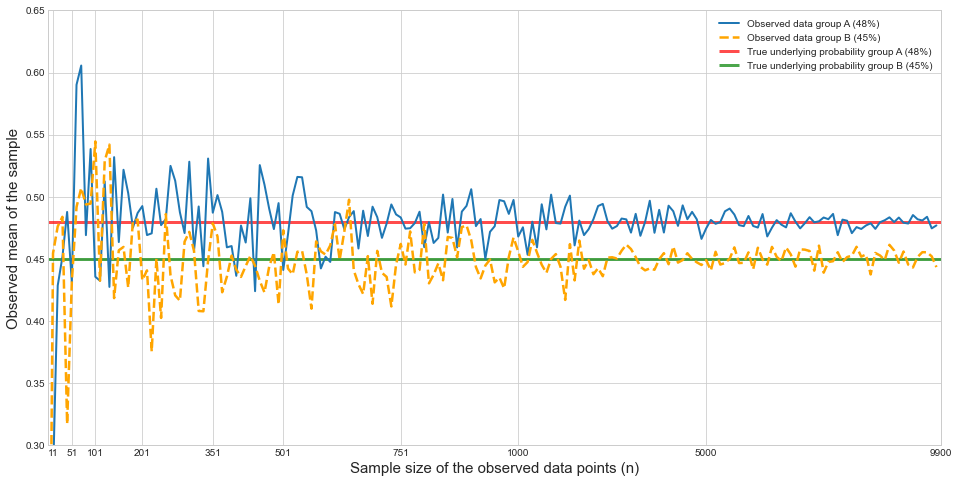

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(mean_test_a, lw=2, label='Observed data group A (48%)')
ax.hlines(y=0.48, xmin=0, xmax=190, color='red', alpha=0.7, lw=3, label='True underlying probability group A (48%)')

ax.plot(mean_test_b, ls='--', lw=2.5, color='orange', label='Observed data group B (45%)')
ax.hlines(y=0.45, xmin=0, xmax=190, color='green', alpha=0.7, lw=3, label='True underlying probability group B (45%)')

ax.set_xlabel('Sample size of the observed data points (n)', size=15, weight='normal')
ax.set_xticks([1, 5, 10, 20, 35, 50, 75, 100, 140, 190])
ax.set_xticklabels([11, 51, 101, 201, 351, 501, 751, 1000, 5000, 9900])
ax.set_xlim(0, 190)

ax.set_ylabel('Observed mean of the sample', size=15)
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.set_ylim(0.3, 0.65)

ax.legend()
;

Every time the dotted orange line crosses the solid blue line, the control group outperformed the test group. Note that the two lines either overlap or remain close until a sample size of ~2000 for both A and B. 

Hopefully from this plot alone, you now understand that you need a *very* large sample when you expect the difference between 2 groups to be very small (e.g., < 0.5%). Sometimes this means your experiment is not viable, and you need to go back to the drawing board. 

Since we are finally talking business, what would happen if we would keep the 'max 10% control group rule'?

In [16]:
control_group = np.arange(1, 500, 3)
test_group = control_group * 9

In [17]:
np.random.seed(1337)
mean_test = [np.mean(bernoulli.rvs(p=0.48, size=x)) for x in test_group]
mean_control = [np.mean(bernoulli.rvs(p=0.45, size=x)) for x in control_group]

''

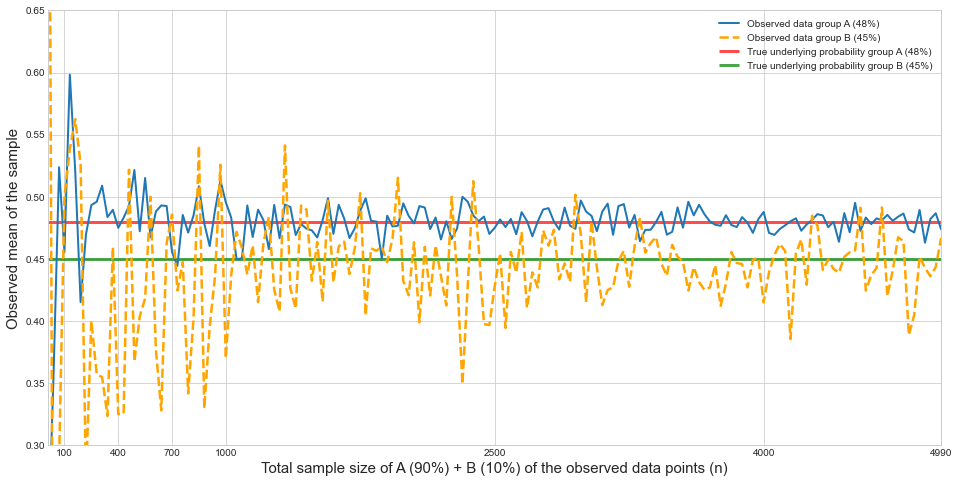

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(mean_test, lw=2, label='Observed data group A (48%)')
ax.hlines(y=0.48, xmin=0, xmax=167, color='red', alpha=0.7, lw=3, label='True underlying probability group A (48%)')

ax.plot(mean_control, ls='--', lw=2.5, color='orange', label='Observed data group B (45%)')
ax.hlines(y=0.45, xmin=0, xmax=167, color='green', alpha=0.7, lw=3, label='True underlying probability group B (45%)')

ax.set_xlabel('Total sample size of A (90%) + B (10%) of the observed data points (n)', size=15)
ax.set_xticks([3, 13, 23, 33, 83, 133, 166])
ax.set_xticklabels([100, 400, 700, 1000, 2500, 4000, 4990])
ax.set_xlim(0, 166)

ax.set_ylabel('Observed mean of the sample', size=15)
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.set_ylim(0.3, 0.65)

ax.legend()
;

Although the observed data from group A stabilizes around a total sample size of ~2500, the observed data from the control group keeps making large deviations from its true underlying probability. Note that for the x-axis value of 4000, the control group consists of 400 (10%) customers, and the test group of 3600 customers (90%).

The practical implication of this insight is that 'more data' alone is not enough, you need more data for the group with the most uncertainty, in this case the control group.

By now I hope you have come to the conclusion that common evaluation techniques to analyze differences in conversion rates have flaws, and that simulation can be remarkably useful. Luckily for us, Bayesian inference can really help interpreting our experimental results, and drawing better conclusions. In part 2 I will show you how. 

--------------------------------

p.s. I am aware of things like frequentist power-analysis, sample size calculators, etc., but a discussion on frequentist-vs-bayesian techniques is not the goal of this article. The goal is to address potential pitfalls in experimentation, enhance your intuition on randomness, and show you a technique that - in my *belief* - is most informative. However, if you are looking for a serious introduction into the differences of frequentist and bayesian techniques, I highly recommend the *The Bayesian New Statistics* paper [2]. Note: the author is a Bayesian :).

### References / further inspiration

Direct references:

- [1]: *Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference* by Cameron Davidson-Pilon (2016).
- [2]: *The Bayesian New Statistics: Hypothesis testing, estimation, meta-analysis, and power analysis from a Bayesian Perspective* by John K. Kruschke and Torrin M. Liddell (2017). [link to article](https://link.springer.com/article/10.3758/s13423-016-1221-4)

Back to the [Proportion test](#Proportion-test).

The following references are not directly cited in this article. However, they were read and re-read with a lot of joy and wonder, and significantly contributed to my understanding and interest of this topic. Therefore, I did not want to leave them out. These references require no technical background.

- *The theory that would not die: how bayes' rule cracked the enigma code, hunted down russian submarines & emerged triumphant from two centuries of controversey* by Sharon Bertsch McGrayne (2011).
- *The Signal and the Noise: why so many predictions fail - but some don't* by Nate Silver (2015).
- *Fooled by Randomness: the hidden role of chance in life and in the markets* by by Nassim Nicholas Taleb (2007).
- *The Black Swan: the impact of the highly improbable* by Nassim Nicholas Taleb (2008).